# Rhea's BIOS 512 Final Project
## Type 1 Diabetes Medical Alert Dog Data

For my final project, I decided to use some of the data I have collected over the past 10 months from my medical alert service dog, Charlie. Charlie helps me to have tighter control of my Type 1 Diabetes by alerting me with a nose bump when my blood sugar is out of range. I was matched with her in March of 2020, so our relationship is still new and getting stronger. For the first few months of the match, she was struggling to correctly alert me, as the process of being paired with a service dog involves a period of "callibration." Therefore, I thought it could be interesting to look at her data, both in regards to her accuracy and my blood sugars. The organization I received her from, EENP (based in Chapel Hill), requiries me to keep intense records of my blood sugars and her alerts, which results in anywhere from 8 to 15 data points a day. As you can expect, there was a lot of data to mess around with.

The data, however, was quite messy. The date column, in particular included both the date and time as one variable, and the time portion was a combination of military time and "AM/PM." Before I was able to begin visualizing the data in R, I had to clean the time and date variable. With my basic R knowledge, I decided it would be best to focus on two months, April and September, and clean those separately before merging them. The majority of the code below is from that proceess. I will use markdowns and comments to explain the process.

In [1]:
# I began by importing the tidyverse and my data, which I imported to my github as a csv file.
library("tidyverse")
eenp = read_csv("https://github.com/rheajaisinghani/BIOS512/raw/main/EENP.csv")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


── Column specification ────────────────────────────────────────────────────────
cols(
  time = col_character(),
  sugar = col_double(),
  charlie = col_character(),
  note = col_character(),
  alert = col_character(),
  retest = col_character(),
  reaction = col_character()
)




In [4]:
# I filtered the large data set to just the April data points.
april_df = eenp %>% 
           filter(str_detect(time, "^4|^04")) %>%
           arrange(time)

# Here, I acheived 3 things. First, I added a leading 0 to all the date values, since some were formatted 
# without and some with. Second, I separated the date from the time, since they were all under one column.
# Lastly, some of the AM times still included the word "AM." I deleted that from those rows sine in military
# time, AM times remain the same.
sep_date = april_df %>%
           mutate(date = gsub("4/", "04/", time)) %>%
           mutate(date = gsub("004/", "04/", date)) %>%
           mutate(date = gsub("104/", "14/", date)) %>%
           mutate(time = gsub("4/", "04/", time)) %>%
           mutate(time = gsub("004/", "04/", date)) %>%
           mutate(date = str_sub(date, 1, 10)) %>%
           mutate(time = str_sub(time, 12, -1)) %>%
           mutate(time = gsub("AM", "", time))

# Here, I filtered the April data to the rows with "PM" since I needed to convert those times to military time.
april_am = sep_date %>% 
           filter(endsWith(time, "PM") == FALSE) %>%
           select(date, time, sugar, charlie, note, alert, retest, reaction)

# Here I took the time variable and created a new variable that was the first two values of the time variable.
fix_time = sep_date %>% 
           filter(endsWith(time, "PM") == TRUE) %>%
           mutate(pm_hour = substr(time, 1,2))

# That new variable called "pm_hour" had two variations, single digit values and double digit values. Since I
# took a substring of the first two values of the time variable, the single digit values included the ":". So
# in this step, I removed the colon from the single digit values and added 12 to them to convert to military time.
# I then replaced the non-military hour in the time variable with this new value.
hour_colon = fix_time %>% filter(endsWith(pm_hour, ":") == TRUE) %>% 
             mutate(pm_hour = substr(pm_hour, 1, 1)) %>% 
             mutate(pm_hour = as.integer(pm_hour) + 12) %>% 
             mutate(pm_hour = as.character(pm_hour)) %>%
             mutate(time = str_replace(time, substr(time, 1, 1), pm_hour)) %>%
             mutate(time = str_sub(time, 1, -4)) %>%
             select(date, time, sugar, charlie, note, alert, retest, reaction)

# For the double digit values, I did not need to remove a colon. For the 12th PM hour, I did not need to add 12, so
# those values remained the same.
hour_nocolon = fix_time %>% 
               filter(endsWith(pm_hour, ":") == FALSE) 
hour_12 = hour_nocolon %>% 
          filter(pm_hour == "12") %>%
          mutate(time = str_sub(time, 1, -4)) %>%
          select(date, time, sugar, charlie, note, alert, retest, reaction)

# For double digit hours not including 12 (10 and 11), I added 12 to them and replaced the original non-military time
# hour with the new values.
hour_no12 = hour_nocolon %>% 
            filter(pm_hour != "12") %>%
            mutate(pm_hour = as.integer(pm_hour) + 12) %>%
            mutate(pm_hour = as.character(pm_hour)) %>%
            mutate(time = str_replace(time, substr(time, 1, 2), pm_hour)) %>%
            mutate(time = str_sub(time, 1, -4)) %>%
            select(date, time, sugar, charlie, note, alert, retest, reaction)

# I then vertically merged all four of the data sets I created to result in one cleaned data set for April. 
# I also created a variable called "month" so I could facet_wrap by month in my visualizations.
april = rbind(april_am, hour_colon, hour_12, hour_no12) %>%
        arrange(date, time) %>%
        mutate(month = "April")

In [8]:
# Here, I use the same process to clean September's data points as I did for April.
sept_df = eenp %>% 
          filter(str_detect(time, "^9|^09")) %>% 
          arrange(time)

sep_date_sept = sept_df %>%
                mutate(date = gsub("9/", "09/", time)) %>%
                mutate(date = gsub("009/", "09/", date)) %>%
                mutate(date = gsub("109/", "19/", date)) %>%
                mutate(date = gsub("209/", "29/", date)) %>%
                mutate(time = gsub("9/", "09/", time)) %>%
                mutate(time = gsub("009/", "09/", date)) %>%
                mutate(date = str_sub(date, 1, 10)) %>%
                mutate(time = str_sub(time, 12, -1)) %>%
                mutate(time = gsub("AM", "", time))

sept_am = sep_date_sept %>% 
          filter(endsWith(time, "PM") == FALSE) %>%
          select(date, time, sugar, charlie, note, alert, retest, reaction)

fix_time_sept = sep_date_sept %>% 
                filter(endsWith(time, "PM") == TRUE) %>%
                mutate(pm_hour = substr(time, 1,2))

hour_colon_sept = fix_time_sept %>% 
                  filter(endsWith(pm_hour, ":") == TRUE) %>% 
                  mutate(pm_hour = substr(pm_hour, 1, 1)) %>%
                  mutate(pm_hour = as.integer(pm_hour) + 12) %>% 
                  mutate(pm_hour = as.character(pm_hour)) %>%
                  mutate(time = str_replace(time, substr(time, 1, 1), pm_hour)) %>%
                  mutate(time = str_sub(time, 1, -4)) %>%
                  select(date, time, sugar, charlie, note, alert, retest, reaction)

hour_nocolon_sept = fix_time_sept %>% 
                    filter(endsWith(pm_hour, ":") == FALSE) 
hour_12_sept = hour_nocolon_sept %>% 
               filter(pm_hour == "12") %>%
               mutate(time = str_sub(time, 1, -4)) %>%
               select(date, time, sugar, charlie, note, alert, retest, reaction)

hour_no12_sept = hour_nocolon_sept %>% 
                 filter(pm_hour != "12") %>%
                 mutate(pm_hour = as.integer(pm_hour) + 12) %>%
                 mutate(pm_hour = as.character(pm_hour)) %>%
                 mutate(time = str_replace(time, substr(time, 1, 2), pm_hour)) %>%
                 mutate(time = str_sub(time, 1, -4)) %>%
                 select(date, time, sugar, charlie, note, alert, retest, reaction)

september = rbind(sept_am, hour_colon_sept, hour_12_sept, hour_no12_sept) %>%
            arrange(date, time) %>%
            mutate(month = "September")

In [74]:
# Here, I vertically merge the cleaned April and September data sets. And now we can finally move on to visualization.
april_sept = rbind(april, september) %>%
  mutate(id = row_number())

In [87]:
eenp_charlie = eenp_id %>%
               filter(alert == "Alert") %>%
               head(1) %>% 
               select(time, id) %>%
               print

# A tibble: 1 x 2
  time                    id
  <chr>                <int>
1 2/24/2020 1:39:26 PM   274


Warning message:
“Removed 10 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


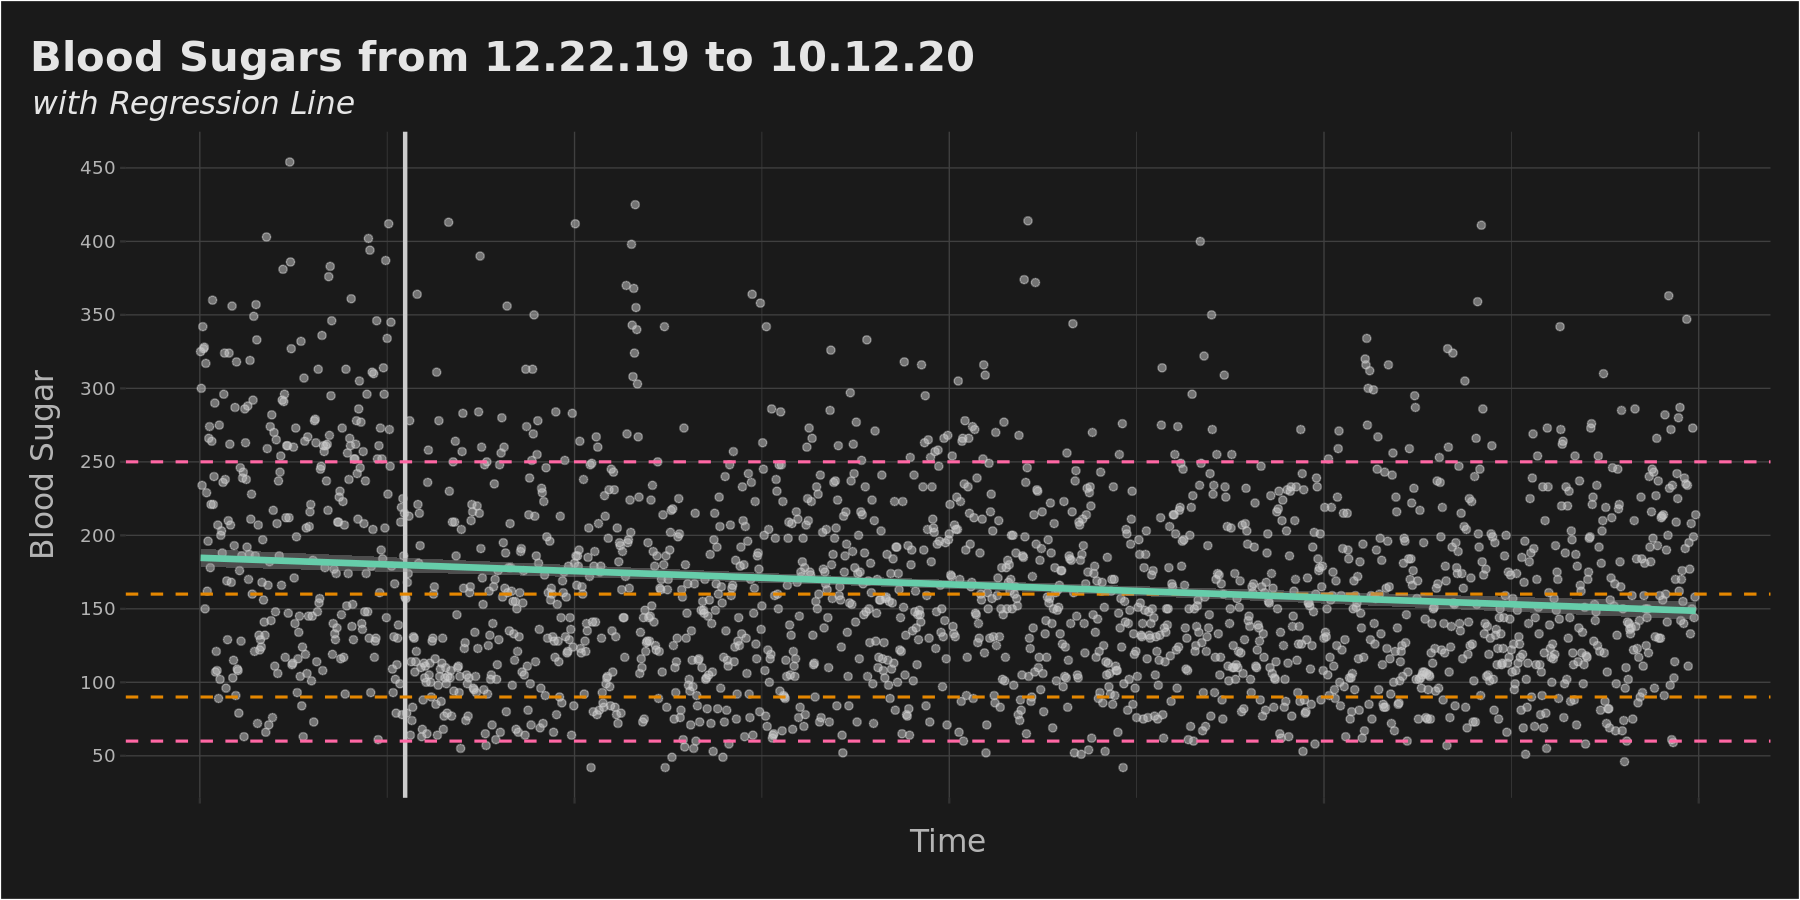

In [94]:
options(repr.plot.res = 150, repr.plot.height = 6, repr.plot.width = 12)

eenp_id = eenp %>% 
          mutate(id = row_number())

overall = ggplot(eenp_id, aes(x = id, y = sugar)) +
          geom_point(alpha = 0.5, color = "grey80") + 
          xlab("Time") + ylab("Blood Sugar") +
          labs(title = "Blood Sugars from 12.22.19 to 10.12.20",
               subtitle = "with Regression Line") +
          scale_y_continuous(breaks=seq(0,500,50)) +
          geom_vline(xintercept = 274, color = "grey80", size = 1) +
          geom_hline(yintercept=90, linetype="dashed", color = "#E58700", size = .7) +
          geom_hline(yintercept=160, linetype="dashed", color = "#E58700", size = .7) +
          geom_hline(yintercept=250, linetype="dashed", color = "#FF67A4", size = .7) +
          geom_hline(yintercept=60, linetype="dashed", color = "#FF67A4", size = .7) +
          geom_smooth(method='lm', formula= y~x, color = "aquamarine3", size = 1.5) +

          theme(plot.title = element_text(colour = "grey90", face = "bold", size = 20),
                plot.title.position = "plot",
                plot.subtitle = element_text(color = "grey90", size = 15, face = "italic"),
                plot.background = element_rect(fill = "grey10"),
                plot.margin = unit(c(0.7, 0.5, 0.7, 0.5), "cm"),
                panel.grid = element_line(size = .3, color = "grey25"),
                axis.title = element_text(color = "grey70", size = 15),
                axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
                axis.title.x = element_text(margin = margin(t = 2, r = 0, b = 0, l = 0)),
                axis.text.y = element_text(color = "grey70"),
                axis.text.x = element_text(color = "transparent"),
                panel.background = element_rect(fill = "transparent", colour = "transparent"),
                panel.grid.minor.y = element_blank())
overall

## Visualization 1
### 10 months of blood sugar data

The first visualization uses the raw, uncleaned data set because I wanted to see the trend in my blood sugars over the 10 month period. I created horizontal dotted lines at blood sugars of 90, 160, 60, and 250 to show more easily which blood sugars are in and out of range. The ideal range would be between 90 and 160, with below 60 and above 250 being dangerous. I also added a white, vertical line to denote when I was matched with Charlie (February 12, 2020) so that it would be easier to see the change in blood sugars before and after being paired with her. This visualization tells a true story. Very soon after being matched with Charlie, the number of dangerous high blood sugars went down quite significantly. You can tell by how much less saturated the points are above the 250 pink line after being matched with her. The most exciting visual, in my opinion, is the regression line. It shows a negative correlation between time and blood sugar, which is exactly what I want to see. I signed up for a medical alert dog to help me stop letting my blood sugars go so high. And that is exactly what this data shows.

Warning message:
“Removed 5 rows containing missing values (geom_point).”


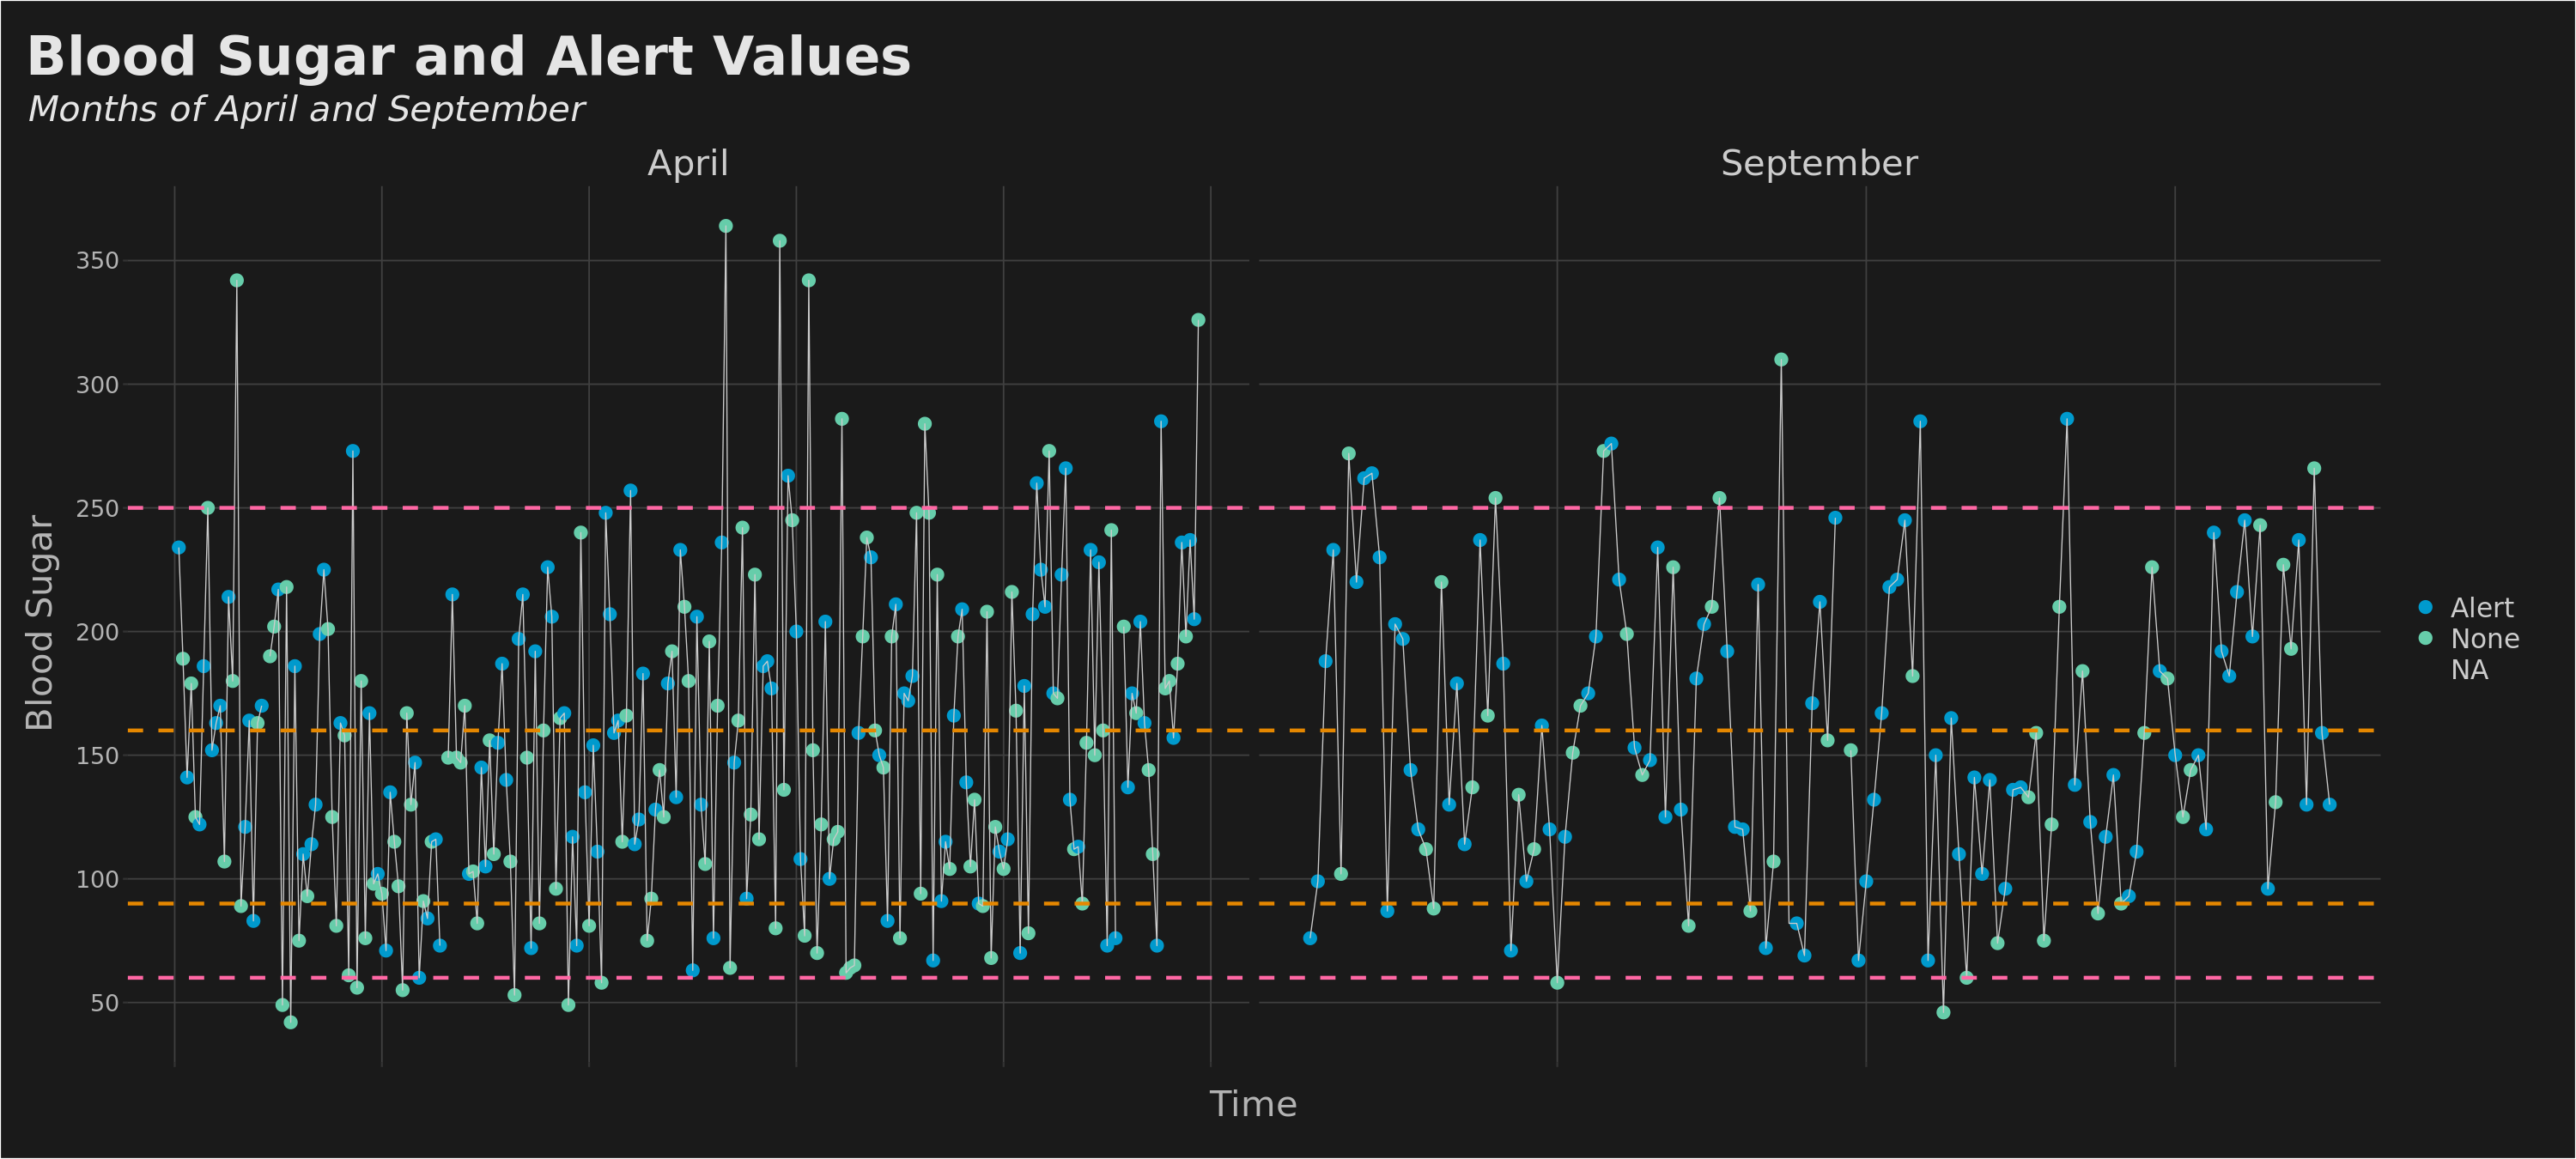

In [100]:
options(repr.plot.res = 150, repr.plot.height = 9, repr.plot.width = 20)

points = ggplot(april_sept, aes(x = id, y = sugar)) +
         geom_point(aes(color=alert), size = 3) +
         scale_colour_manual(values=c("deepskyblue3", "aquamarine3")) +
         geom_path(color = "grey80", size = 0.3) +
         ylab("Blood Sugar") + xlab("Time") +
         geom_hline(yintercept=90, linetype="dashed", color = "#E58700", size = 1) +
         geom_hline(yintercept=160, linetype="dashed", color = "#E58700", size = 1) +
         geom_hline(yintercept=250, linetype="dashed", color = "#FF67A4", size = 1) +
         geom_hline(yintercept=60, linetype="dashed", color = "#FF67A4", size = 1) +
         facet_wrap(~month, scales = "free_x") +
         scale_y_continuous(breaks=seq(0,350,50)) +
         labs(title = "Blood Sugar and Alert Values",
              subtitle = "Months of April and September",
              color = "Alert") +

         theme(plot.title = element_text(colour = "grey90", face = "bold", size = 30),
               plot.title.position = "plot",
               plot.subtitle = element_text(color = "grey90", size = 20, face = "italic"),
               plot.background = element_rect(fill = "grey10"),
               plot.margin = unit(c(0.7, 0.5, 0.7, 0.5), "cm"),
               panel.grid = element_line(size = .4, color = "grey25"),
               axis.title = element_text(color = "grey70", size = 20),
               axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
               axis.title.x = element_text(margin = margin(t = 2, r = 0, b = 0, l = 0)),
               axis.text.y = element_text(color = "grey70", size = 13),
               axis.text.x = element_text(color = "transparent"),
               panel.background = element_rect(fill = "transparent", colour = "transparent"),
               panel.grid.minor.x = element_blank(),
               panel.grid.minor.y = element_blank(),
               strip.text = element_text(color = 'grey70'),
               strip.background = element_rect(fill = "transparent"),
               legend.background = element_rect(fill = "transparent"),
               legend.text = element_text(color = "grey80", size = 15),
               legend.key = element_rect(fill = "transparent"),
               legend.title = element_text(color = 'transparent'),
               legend.box.margin = unit(c(0, 0.4, 0, 0), "cm"),
               strip.text.x = element_text(size = 20, color = "grey80"))
points

## Visualization 2
### Alert and blood sugar data from April and September

For this second visualization, I wanted to compare Charlie's effectiveness 2 months after our match versus 6 months after our match. To do so, I cleaned the data for both April and September and merged them together. This dot and line graph shows both my blood sugar fluctuations and Charlie's alerts. It also shows the same horizontal lines to denote in and out of range blood sugars. Immediately you can tell that the April graph is much more saturated than the September one. That is because at the beginning of our match, Charlie was still figuring out my scent, so I was picking up on any unusual behavior she showed as an alert. 6 months into the match, however, Charlie was much more confident in her ability to alert me correctly and I was not having to guess as much. Therefore, there are less alerts in September, a good sign at her ability to alert correctly. We can also see a significant decrease in the number of dangerous highs in September compared to April. In September, she barely let me pass 300 once, while in April, my blood sugar was above 300 5 times, none of which she alerted to. What I find most impressive are the alerts between the orange and pink lines. Compared to September, she caught a much higher percentage of those highs and lows, which you can tell from the number of blue versus green dots.

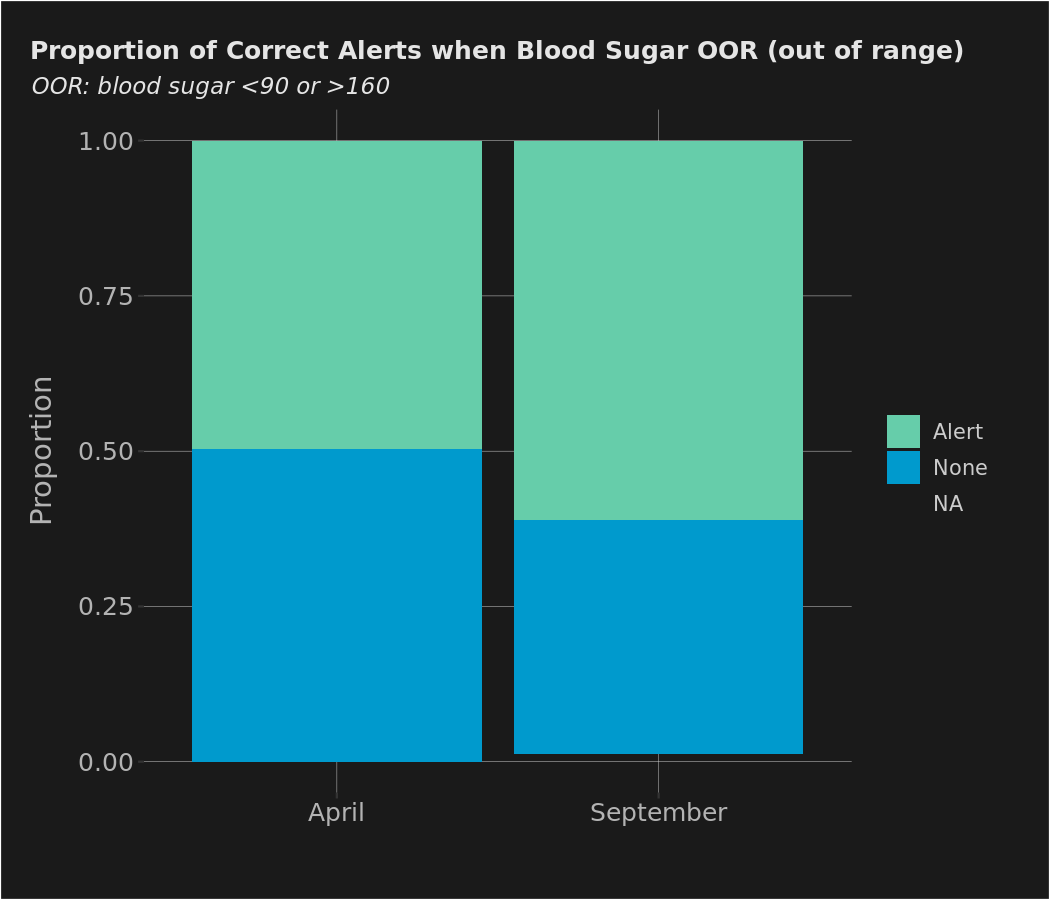

In [101]:
options(repr.plot.res = 150, repr.plot.height = 6, repr.plot.width = 7)

outofrange = april_sept %>% 
             group_by(month) %>% 
             filter(sugar < 90 | sugar > 160)
bar = ggplot(outofrange, aes(x = month, fill = alert)) + 
      geom_bar(position = "fill") +
      xlab("") + ylab("Proportion") +
      labs(title = "Proportion of Correct Alerts when Blood Sugar OOR (out of range)",
           subtitle = "OOR: blood sugar <90 or >160",
           color = "Alert") + 
      scale_fill_manual(values=c("aquamarine3", "deepskyblue3")) +

      theme(plot.title = element_text(colour = "grey90", face = "bold", size = 12),
            plot.title.position = "plot",
            plot.subtitle = element_text(color = "grey90", size = 11, face = "italic"),
            plot.background = element_rect(fill = "grey10"),
            plot.margin = unit(c(0.7, 0.5, 0.7, 0.5), "cm"),
            panel.grid = element_line(size = .1, color = "grey85"),
            axis.title = element_text(color = "grey70", size = 14),
            axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
            axis.title.x = element_text(margin = margin(t = 2, r = 0, b = 0, l = 0)),
            axis.text.y = element_text(color = "grey70", size = 12),
            axis.text.x = element_text(color = "grey70", size = 12),
            panel.background = element_rect(fill = "transparent", color = "transparent"),
            panel.grid.minor.x = element_blank(),
            panel.grid.minor.y = element_blank(),
            legend.background = element_rect(fill = "transparent"),
            legend.text = element_text(color = "grey80", size = 10),
            legend.key = element_rect(fill = "transparent"),
            legend.title = element_text(color = 'transparent'),
            legend.box.margin = unit(c(0, 0.4, 0, 0), "cm"))
bar

## Visualization 3
### Proportion of out of range blood sugars alerted to

For this last visualization, I wanted to extract some of the information from the second visualization and make it more clear. It is obvious upon first glance that Charlie's alerts got much better from the 2 to 6 month period, but this chart allows us to see just by how much. I filtered the data to just the out of range alerts and then created a stacked bar chart to see just how they stacked up. In April, we can seee that Charlie was only catching half of the out of range blood sugars. In September, however, that number increased to around 60%. This is great news to me, and it does not even take into account out of range sugars she alerted to 30 or 60 minutes before.